# Supplementary Fig. 5c,d *Xenopus tropicalis* PCA eigenvectors projected on genomic coordinates

### Supplementary Fig. 5c

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
source_data_path = 'SourceData'
sup_fig_3 = 'Supplementary_Fig.3'
sup_fig_5 = 'Supplementary_Fig.5'

paths_files_fig_3 = os.path.join(source_data_path,sup_fig_3)
paths_files_fig_5 = os.path.join(source_data_path,sup_fig_5)

#input files:
recombination_rates_file = os.path.join(paths_files_fig_5, sup_fig_5+'a', 'Xtropicalis_Recombination_Rates_Final.tsv')  # 289 KB
chromosome_sizes_file = os.path.join(paths_files_fig_3, sup_fig_3+'a', 'All_Chr_lengths.tsv')    # 1.7 KB
file_path_centrome_pos = os.path.join(paths_files_fig_3, sup_fig_3+'a', 'Xtr_centromeric_repeats.tsv')  # 206 B
species_table_file = os.path.join(paths_files_fig_5, 'Species_table_final.tsv')  # 6.5 KB

repeat_masker_file = os.path.join(paths_files_fig_5, sup_fig_5+'c', sup_fig_5+'c_RM_JC.tsv')  # 282 MB !!!
repeat_idmap_file  = os.path.join(paths_files_fig_5, sup_fig_5+'c', 'Repeat_Motif_IndexMap_table.tsv')
repeat_motif_file  = os.path.join(paths_files_fig_5, sup_fig_5+'c', sup_fig_5+'c_motifs.tsv')  # 53 MB !!!
repeat_color_file  = os.path.join(paths_files_fig_5, sup_fig_5+'c', sup_fig_5+'c_colors.json')

hist_blue_file = os.path.join(paths_files_fig_5, sup_fig_5+'d', sup_fig_5+'d_blue.json')
hist_red_file = os.path.join(paths_files_fig_5, sup_fig_5+'d', sup_fig_5+'d_red.json')
hist_green_file = os.path.join(paths_files_fig_5, sup_fig_5+'d', sup_fig_5+'d_green.json')
hist_orange_file = os.path.join(paths_files_fig_5, sup_fig_5+'d', sup_fig_5+'d_orange.json')

out_dir_figs = paths_files_fig_5

In [6]:
Mb = 1000000

def load_all_chromosome_sizes(file_path, Spe_abr):
    chr_sizes = pd.read_csv(file_path,sep='\t')  
    if Spe_abr== '':
        chr_sizes =chr_sizes[chr_sizes.Abr=='Chr']
    else:
        chr_sizes =chr_sizes[chr_sizes.Abr==Spe_abr]
    return(chr_sizes)

def load_Densities(file_path):
    Motifs = pd.read_csv(file_path, sep='\t')
    Motifs = Motifs.fillna(0)
    return(Motifs)

def load_id_map(file_path):
    idmap = dict()
    with open(file_path, 'r') as f:
        for line in f:
            fields = line.strip().split("\t")
            if fields[0] == "ID":
                continue
            idmap[int(fields[0])] = fields[1]
    return idmap

In [8]:
# Load files:
Xtrop_centromere_positon = pd.read_csv(file_path_centrome_pos,sep='\t')
Rec_rate = pd.read_csv(recombination_rates_file, sep='\t')
ID_map = load_id_map(repeat_idmap_file)

Repeat_Masker_with_JC = pd.read_csv(repeat_masker_file, sep='\t')
Repeat_Masker_with_JC['Motif'] = Repeat_Masker_with_JC.ID.apply(ID_map.get)
Repeat_Masker_with_JC['Class'] = Repeat_Masker_with_JC.Motif.apply(lambda x: x.split(':',maxsplit=1)[0])

Motifs = pd.read_csv(repeat_motif_file, sep="\t")

#Dataframe for Chromosome sizes:
Specie_name = 'Xtropicalis'
chr_sizes_xtr = load_all_chromosome_sizes(chromosome_sizes_file, 'Xtr')
chr_sizes = chr_sizes_xtr  #load_all_chromosome_sizes(chromosome_sizes, 'Xtr')

# Selection Repeats to plot:
with open(repeat_color_file,'r') as f:
    dictionary_input = json.load(f)
with open(hist_blue_file,'r') as f:
    hist_blue_list = json.load(f)
with open(hist_red_file,'r') as f:
    hist_red_list = json.load(f)
with open(hist_green_file,'r') as f:
    hist_green_list = json.load(f)
with open(hist_orange_file,'r') as f:
    hist_orange_list = json.load(f)    


In [9]:
from matplotlib import colors

def assign_colors(dictionary_input, Repeat_Masker_with_JC, Motifs):
    reordered_repeats = dict()
    dictionary_output=dict()
    for color_scheme in dictionary_input.keys():
        r_repeats = Motifs.columns[Motifs.columns.isin(dictionary_input[color_scheme])].to_list()
        r_repeats = Repeat_Masker_with_JC[Repeat_Masker_with_JC.Motif.isin(r_repeats)].groupby('Motif').JC.median().sort_values().index.to_list()
        JC_values = Repeat_Masker_with_JC[Repeat_Masker_with_JC.Motif.isin(r_repeats)].groupby('Motif').JC.median().sort_values()
        color_ = plt.cm.get_cmap(color_scheme)  
        
        norm = colors.Normalize(JC_values.min()*.1 -.1, JC_values.max()*1.1)
        
        for repeat in r_repeats:
            dictionary_output[repeat] = color_(norm(Repeat_Masker_with_JC[Repeat_Masker_with_JC.Motif==repeat].JC.median()))

            
        reordered_repeats[color_scheme] = Motifs[r_repeats].sum().sort_values().index.to_list()
    return(dictionary_output,reordered_repeats)


def histogram_repeats_Motif_v3(list_repeats_, color_chosen, repeat_description, out_fig_name):
    Df = pd.DataFrame(Repeat_Masker_with_JC[(Repeat_Masker_with_JC.Motif.isin(list_repeats_))].Motif.value_counts())
    list_repeats_ = Df[Df.Motif>50].index.to_list()    
    list_repeats_ = Repeat_Masker_with_JC[(Repeat_Masker_with_JC.Motif.isin(list_repeats_))].groupby('Motif').JC.median().sort_values().index.to_list()
    color_Rep = []
    list_to_plot = []
    
    fig=plt.figure(figsize=(12,3))
    fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
    ax=fig.add_subplot(111)#fig, ax = plt.subplot(1,1, figsize=(12,3.5))

    list_repeats_to_show=[]
    for repeat in list_repeats_ :
        #repeat = list_repeats_[i]
        JC_list = Repeat_Masker_with_JC[(Repeat_Masker_with_JC.Motif==repeat)].JC
        if (len(JC_list)>2):
            list_to_plot.append(JC_list.to_list())
            list_repeats_to_show.append(repeat)
        color_Rep.append(Repeat_colors_dict[repeat])
    
    ax.hist(list_to_plot, bins=100, range=(0,0.8), stacked=True,  color=color_Rep, label=list_repeats_to_show)
    ax.set_xlabel('JC distance')
    ax.set_ylabel('Frequency')
    n_cols = int(np.ceil(len(list_repeats_)/float(12))) 
    ax.legend( loc=2, bbox_to_anchor=(1,1), frameon=False, ncol=n_cols)
    title_ = ''.join(("$",Specie_name[0],'. ',Specie_name[1:],"$",'\n',repeat_description))
    plt.title(title_)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
     
    if  len(out_fig_name)  >0:  
        plt.savefig(out_fig_name,bbox_inches='tight', transparent=True,)

    #title = '\n'.join((Specie_name, repeat_description))
    #plt.title(title)
    plt.xlim(0,0.75)
    plt.show()
    return()


def spatial_distibution_repeatsLenght_vs_JCdistance_v3(Density_df, motifs_to_plot, Motif_color_dict, Xtrop_centromere_positon,Chr_sizes, title, max_y_value, out_fig_name, Rec_rate, draw_rec_line):
    Mb = 1000000
    if title == '':
        title = 'Repeat Landscape'
        
    list_chromosomes = Chr_sizes.Chr.tolist()
    
    CTR_pos_Chr1 = list(Xtrop_centromere_positon[Xtrop_centromere_positon.Chr=='Chr1'].TandemRepeats)[0]
    Largest_chr_len = float(Chr_sizes.Length.max())*1.1
    
    max_axis = max_y_value
    
    counter = 0
    fig, axs = plt.subplots(len(list_chromosomes), figsize=(18,len(list_chromosomes)*1.2))
    
    for Chr_ in list_chromosomes:
        
        To_plot = Density_df[Density_df.Chr==Chr_]
        Chr_size_ = list(Chr_sizes[Chr_sizes.Chr==Chr_].Length)[0]
        CTR_pos = list(Xtrop_centromere_positon[Xtrop_centromere_positon.Chr==Chr_].TandemRepeats)[0]
        delta_centromere = CTR_pos_Chr1 - CTR_pos
        CTR_pos_normalized =(CTR_pos+delta_centromere)/Largest_chr_len
        chr_size_normalized = (Chr_size_+delta_centromere)/Largest_chr_len
        
        axs[counter].set_xlim((0, 1))
        axs[counter].set_ylim((-(max_axis*.25), max_axis*1.05))
        axs[counter].text((CTR_pos+delta_centromere)/Largest_chr_len, max_axis, Chr_, fontsize=12, horizontalalignment='center')
        axs[counter].axhline(max_axis/2,xmin=delta_centromere/Largest_chr_len,xmax=chr_size_normalized, color='gray' , linestyle = ':', linewidth=1, alpha=0.75)
        if counter == 0:
            axs[counter].text(CTR_pos_normalized,(max_axis)*1.5,title, fontsize=15, horizontalalignment='center')
            axs[counter].text(-0.001,max_axis/2,str(max_y_value/2000), fontsize=12, horizontalalignment='center', va='center', ha='right')
            axs[counter].text(-0.025,max_y_value/2,str('kb/Mb'), fontsize=12, horizontalalignment='center', va='center', ha='center',  rotation='90') 

        for tick_10Mb in range(0, Chr_size_, 10*Mb):
            normalized_tick = (tick_10Mb  +delta_centromere)/Largest_chr_len  
            axs[counter].axvline(normalized_tick, ymin=-max_axis*.25, ymax= (max_axis*.25)/(max_y_value+max_axis*.25),  alpha=1, color='gray', linewidth=2)
        
        previous = 0
        x_positon = To_plot['Start'] + delta_centromere
        x_positon_normalized = (x_positon)/Largest_chr_len
        for repeat_name in motifs_to_plot :
            axs[counter].fill_between(x_positon_normalized, previous, previous + To_plot[repeat_name].astype(float),  color=Motif_color_dict[repeat_name], linewidth=0)  
            previous = previous + To_plot[repeat_name].astype(float)
        
        axs[counter].spines['top'].set_visible(False)
        axs[counter].spines['right'].set_visible(False)
        axs[counter].spines['bottom'].set_visible(False)
        axs[counter].spines['left'].set_visible(False)
        axs[counter].get_xaxis().set_ticks([])
        axs[counter].get_yaxis().set_ticks([])
        
        
        if len(Rec_rate) > 0:
            x_positon_RR = (Rec_rate[Rec_rate.Chr==Chr_]['Pos'] + Rec_rate[Rec_rate.Chr==Chr_].delta_pos/2) + delta_centromere
            x_positon_normalized_RR = (x_positon_RR)/Largest_chr_len

            axs[counter].fill_between(x_positon_normalized[x_positon_normalized<min(x_positon_normalized_RR)],-max_y_value*.14,-max_y_value*.16, color='black')
            axs[counter].fill_between(x_positon_normalized[x_positon_normalized>max(x_positon_normalized_RR)],-max_y_value*.14,-max_y_value*.16, color='black')
            axs[counter].scatter(x_positon_normalized_RR , [-(max_axis*.15)]*len(Rec_rate[Rec_rate.Chr==Chr_]['Pos'] ), c=Rec_rate[Rec_rate.Chr==Chr_]['Smooth_Recombination_Rate'], cmap='Greys', s=70, alpha=.8, marker="o", linewidth=0)
            if draw_rec_line ==True:
                axs[counter].plot(x_positon_normalized_RR,Rec_rate[Rec_rate.Chr==Chr_].Smooth_Recombination_Rate*max_y_value/Rec_rate.Smooth_Recombination_Rate.max(), color='black', linewidth=2)
                if counter == 0:
                    axs[counter].text(chr_size_normalized*1.001,max_axis/2,''.join((str(Rec_rate.Smooth_Recombination_Rate.max()/2)[:3],' cM/Mb')), fontsize=8, ha='left', va='center', )

            
            if counter == 0:
                axs[counter].text(chr_size_normalized*1.001,-(max_axis*.15),str('Recombination\nRate'), fontsize=11, horizontalalignment='center', va='center', ha='left', fontweight='bold' )
         
        axs[counter].scatter(CTR_pos_normalized, -(max_axis*.15), alpha=.8, s=150, facecolor='none', edgecolors='red',  marker="*")#color='white')  # Centromere dot at the center of each chr
        counter=counter+1
        
    plt.tight_layout()
    
    if len(out_fig_name)>0:
        print("Saved as", out_fig_name)
        plt.savefig(out_fig_name,bbox_inches='tight', transparent=True,)
    
    plt.show()
    
    return()


Saved as SourceData/Supplementary_Fig.5/Supplementary_Fig.5c_Repeat_Landscape_wOrange.pdf


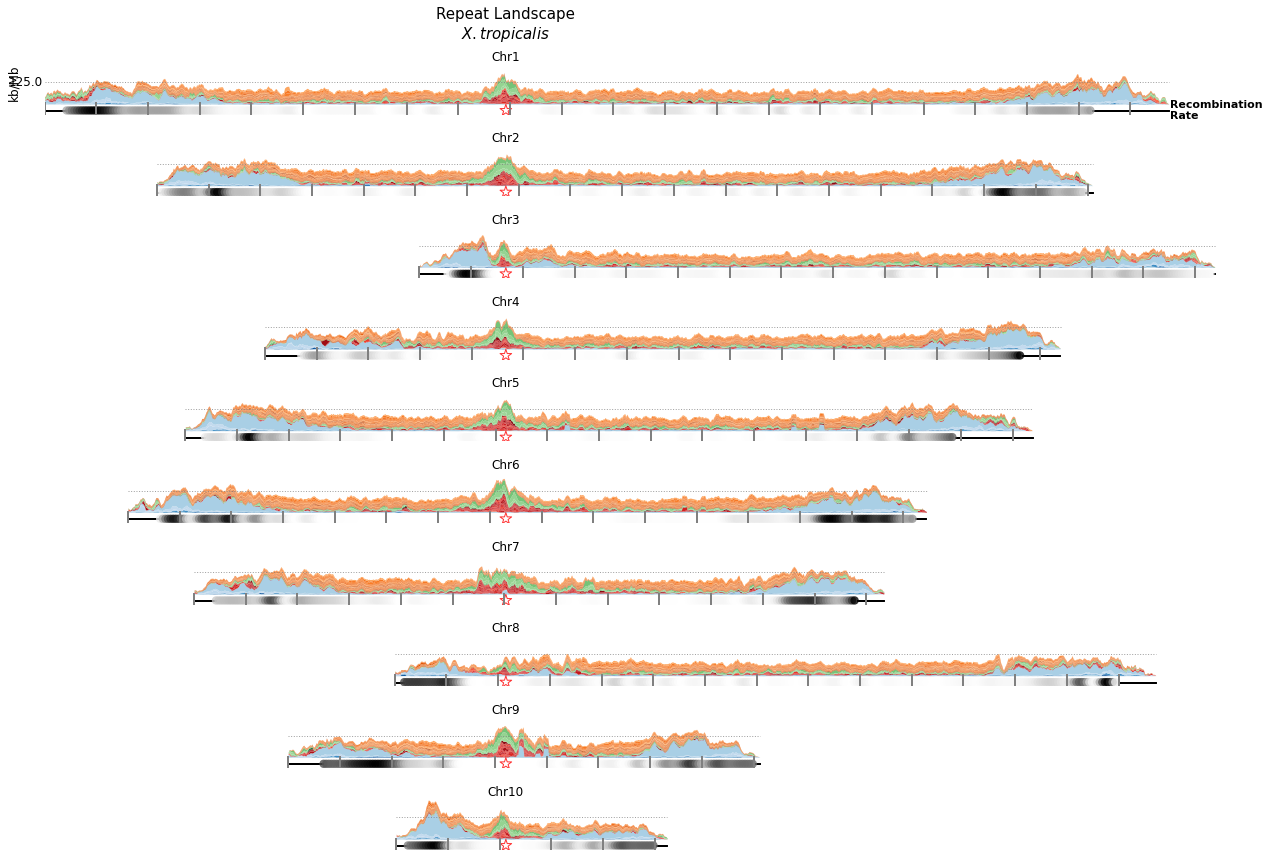

()

In [10]:
# CR1, L1, DNA transposons, Satellites

Repeat_colors_dict, Repeats_ordered_by_JC = assign_colors(dictionary_input, Repeat_Masker_with_JC, Motifs)

motifs_to_plot =  Repeats_ordered_by_JC['Blues'] + Repeats_ordered_by_JC['Reds'] + Repeats_ordered_by_JC['Greens'] + Repeats_ordered_by_JC['Oranges']
max_y_value =  250000
title = 'Repeat Landscape\n$X. tropicalis$'
Specie_name = 'Xtropicalis'
out_fig_name = os.path.join(out_dir_figs, paths_files_fig_5, sup_fig_5+'c_Repeat_Landscape_wOrange.pdf')
spatial_distibution_repeatsLenght_vs_JCdistance_v3(Motifs, motifs_to_plot, Repeat_colors_dict, Xtrop_centromere_positon,chr_sizes_xtr, title, max_y_value, out_fig_name,Rec_rate,False)


### Supplementary Fig. 5d

SourceData/Supplementary_Fig.5/Supplementary_Fig.5d_JC_Subtelomeric_Sat.pdf


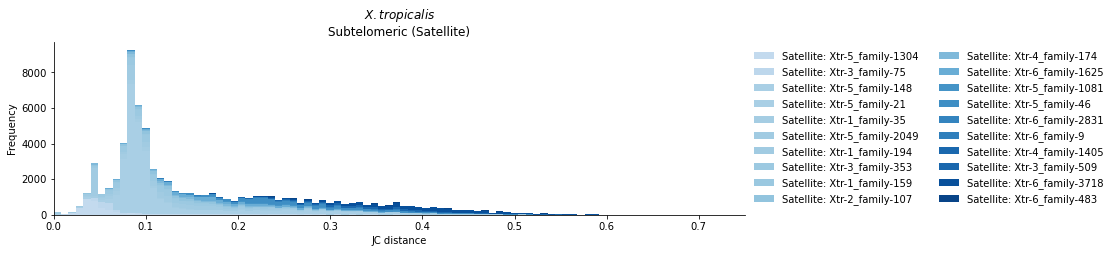

SourceData/Supplementary_Fig.5/Supplementary_Fig.5d_JC_Pericentromeric_L1.pdf


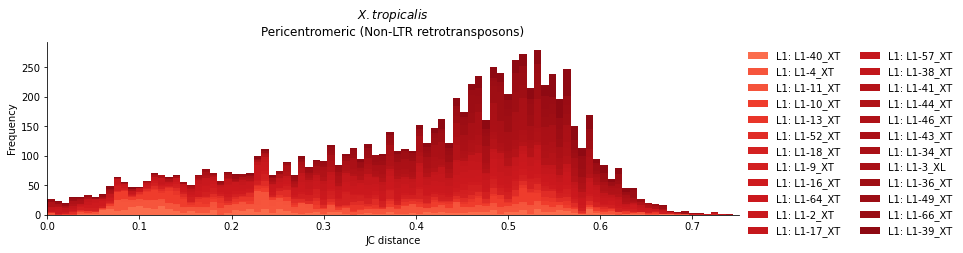

SourceData/Supplementary_Fig.5/Supplementary_Fig.5d_JC_Pericentromeric_CR1.pdf


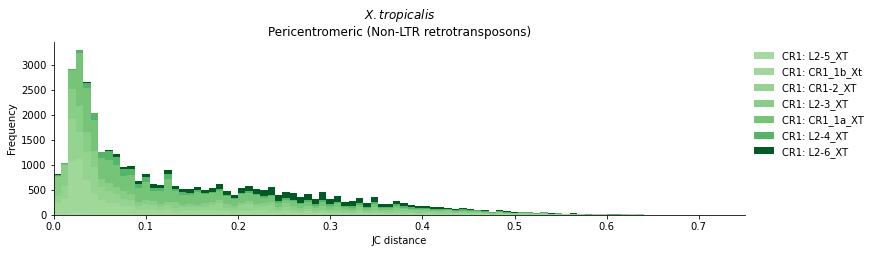

SourceData/Supplementary_Fig.5/Supplementary_Fig.5d_JC_Arms_DNA.pdf


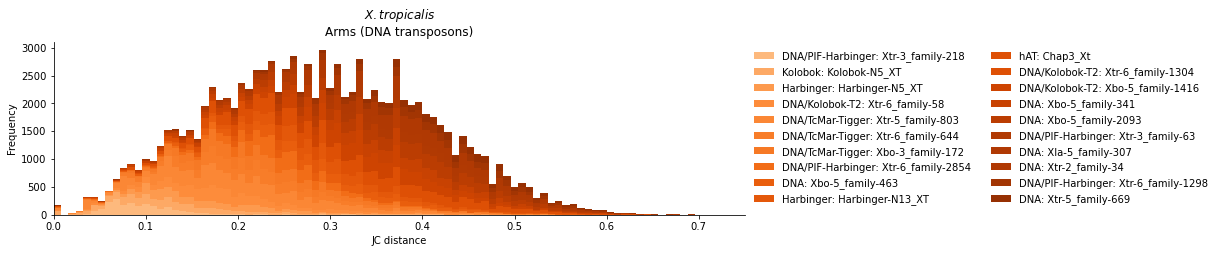

()

In [11]:
out_fig_name = os.path.join(source_data_path, sup_fig_5, sup_fig_5+'d')
out_fig_name_JC = out_fig_name + '_JC_Subtelomeric_Sat.pdf'
print(out_fig_name_JC)
histogram_repeats_Motif_v3(hist_blue_list,Repeat_colors_dict,'Subtelomeric (Satellite)',out_fig_name_JC)
out_fig_name_JC = out_fig_name + '_JC_Pericentromeric_L1.pdf'
print(out_fig_name_JC)
histogram_repeats_Motif_v3(hist_red_list,Repeat_colors_dict,'Pericentromeric (Non-LTR retrotransposons)',out_fig_name_JC)
out_fig_name_JC = out_fig_name + '_JC_Pericentromeric_CR1.pdf'
print(out_fig_name_JC)
histogram_repeats_Motif_v3(hist_green_list,Repeat_colors_dict,'Pericentromeric (Non-LTR retrotransposons)',out_fig_name_JC)
out_fig_name_JC = out_fig_name + '_JC_Arms_DNA.pdf'
print(out_fig_name_JC)
histogram_repeats_Motif_v3(hist_orange_list,Repeat_colors_dict,'Arms (DNA transposons)',out_fig_name_JC)

### About centromeres:
# CR1, Gypsy,BEL are elements found  in pericentromeric regions of Drosophila {Bracewell, 2019}. There regions are silenced?
# There is evidence of expression of endogenous retrovirus localized in the pericentromeres of modern humans {Zahn, 2015}.
#KEEP Figure SE # DONE! : .../X_tropicalis_V10Final/IGC_7/Final Files/Figures/December2019_Figures/Used/Final/Figure\ SE